In [40]:
## Training
import sys , os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import adam_v2
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint
from keras.models import load_model
from keras.models import model_from_json

In [41]:
## Training
num_features = 64
num_labels = 7
batch_size = 64
epochs = 100
width, height = 48,48

x = np.load('fdataX.npy')
y = np.load('flabels.npy')

x-=np.mean(x, axis=0)
x/=np.std(x, axis=0)

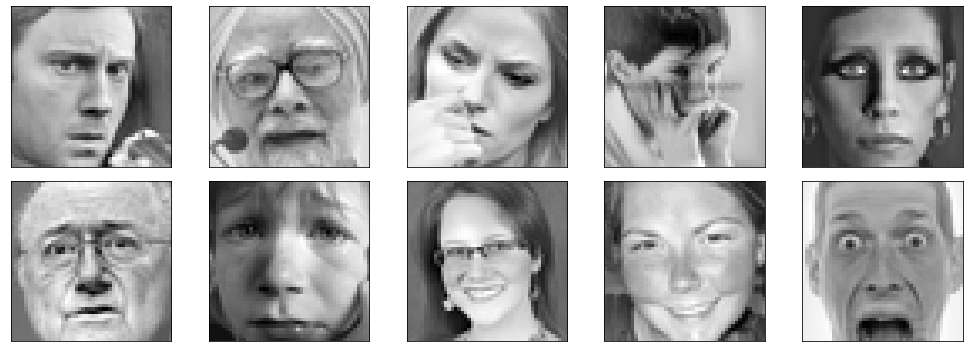

In [43]:
fig = plt.figure(1, (14, 5))

k = 0
for i in range(2):
    for j in range(5):
        k += 1
        ax = plt.subplot(2, 5, k)
        ax.imshow(x[k-1].reshape((48,48)),interpolation='none', cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
plt.tight_layout()

In [5]:
## splitting into training, validation and testing data
X_train, X_test, Y_train, Y_test = train_test_split(x,y,test_size=0.1,random_state=42)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.1, random_state=41)

In [6]:
## Saving the test samples to be used later
np.save('modXtest',X_test)
np.save('modYtest',Y_test)

In [7]:
## desinging the CNN
model = Sequential()

model.add(Conv2D(num_features, kernel_size=(3,3), activation='relu',input_shape=(width, height, 1), data_format='channels_last', kernel_regularizer=l2(0.01)))
model.add(Conv2D(num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.6))

model.add(Conv2D(2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.6))

model.add(Conv2D(2*2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.6))

model.add(Conv2D(2*2*2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.6))

model.add(Flatten())

model.add(Dense(2*2*2*num_features, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2*2*num_features, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2*num_features, activation='relu'))
model.add(Dropout(0.6))
          
model.add(Dense(num_labels, activation='softmax'))
          
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 23, 23, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 23, 23, 128)       7

In [8]:
## Compiing the model with adam optimixer and categorical crossentropy loss
model.compile(loss=categorical_crossentropy,
             optimizer=adam_v2.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
             metrics=['accuracy'])

In [9]:
## Training the model
model.fit(np.array(X_train), np.array(Y_train),
         batch_size=batch_size,
         epochs=epochs,
         verbose=1,
         validation_data=(np.array(X_valid), np.array(Y_valid)),
         shuffle=True)

Epoch 1/100
455/455 [==============================] - 830s 2s/step - loss: 2.1013 - accuracy: 0.2054 - val_loss: 1.8255 - val_accuracy: 0.2591
Epoch 2/100
455/455 [==============================] - 820s 2s/step - loss: 1.8562 - accuracy: 0.2404 - val_loss: 1.8168 - val_accuracy: 0.2594
Epoch 3/100
455/455 [==============================] - 4083s 9s/step - loss: 1.8374 - accuracy: 0.2475 - val_loss: 1.8024 - val_accuracy: 0.2594
Epoch 4/100
455/455 [==============================] - 816s 2s/step - loss: 1.8205 - accuracy: 0.2509 - val_loss: 1.7816 - val_accuracy: 0.2594
Epoch 5/100
455/455 [==============================] - 815s 2s/step - loss: 1.7842 - accuracy: 0.2694 - val_loss: 1.7178 - val_accuracy: 0.3015
Epoch 6/100
455/455 [==============================] - 781s 2s/step - loss: 1.7336 - accuracy: 0.2922 - val_loss: 1.5950 - val_accuracy: 0.3328
Epoch 7/100
455/455 [==============================] - 780s 2s/step - loss: 1.6627 - accuracy: 0.3265 - val_loss: 1.6065 - val_accuracy

In [10]:
## Saving the model to be used later
model_json = model.to_json()
with open("model.json","w") as json_file:
          json_file.write(model_json)
model.save("model_100epochs.h5")
print("Saved model to disk")

Saved model to disk
